<a href="https://colab.research.google.com/github/uchiharon/Kidney_Stone_Diagnosis_with_CNN_and_VAE/blob/main/AVE_Kin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KIDNEY STONE DIAGNOSIS UTILIZING DEEP-LEARNING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Packages

Started by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot graphs and display images in our training and validation data.

In [2]:
# Helper libaries
import os
import numpy as np
import math
import glob
import shutil

# import tensorflow libarys
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# keras layers
from keras.activations import selu
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation,MaxPooling2D
from keras.layers import LeakyReLU
from keras.layers import Multiply, Add
from keras import backend as K
from keras.layers.normalization.batch_normalization import BatchNormalizationBase
from keras.layers.core.lambda_layer import Lambda
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization


# Import logger
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


# Building the Variable Autoencoder

A variable autoencoder is a type of autoencoder neural network that is designed to handle sequential data, such as time series or text. It is composed of an encoder and a decoder, which are both neural networks. The encoder maps the input data to a latent representation, or a compressed version of the data, and the decoder maps the latent representation back to the original input data.

The key feature of a variable autoencoder is that it is able to learn an efficient representation of the input data that is capable of capturing the underlying structure and patterns of the data. This is achieved by using an encoding function that is able to capture the dependencies between the input variables and compress them into a lower-dimensional space. The decoder then reconstructs the original data from this compressed representation.

One of the main uses of variable autoencoders is for dimensionality reduction and feature extraction, as they can learn to identify and extract the most relevant features of the input data. They can also be used for tasks such as anomaly detection and data generation, by learning to reconstruct the normal patterns of the data and detecting deviations from these patterns.





In [3]:
# Load the normal dataset

image_dir = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Normal"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Normal/1.3.46.670589.33.1.63715894847742042700001.5509827303443763175.png',
 '/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Normal/1.3.46.670589.33.1.63737239150311509600001.5074482997916460493.png']

In [ ]:
# Preview the number of image
len(images)

828

In [ ]:
# Load the kidney stone dataset
image_dir2 = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Kidney_stone"
images2 = [os.path.join(image_dir2, image) for image in os.listdir(image_dir2)]
images2[:2]

['/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Kidney_stone/1.3.46.670589.33.1.63742939456616450900001.5200753212886535539.png',
 '/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Kidney_stone/1.3.46.670589.33.1.63741210469363203700001.5207129079094969383.png']

In [ ]:
# Preview the number of image
len(images2)

126

In [ ]:
# combine normal and kidney stone data
images = images + images2

In [ ]:
len(images)

954

(1092, 1110)


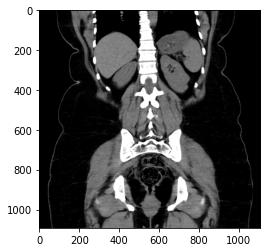

In [ ]:
# Preview data

reader = plt.imread(images[10])
alx = plt.imshow(reader, cmap="gray")
print(alx.get_size())

In [ ]:
len(images)

954

In [ ]:
# preprocess
image_size = 128

def preprocess(image):
    ''' Preprocessing of imaging in the dataset. The files are read from there 
    url and decode as png (the images file format). The image is the casted to
    float and resize 64 since all image must have thesame size in other to build
    the model. The images pixels values is then normalised by dividing by 255 
    and reshaped to a 3D
    
    args:
        image: the path to the image to be preprocessed
    
    return:
        image: preprocessed imaged
    '''

    image = tf.io.read_file(image)
    image = tf.io.decode_png(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 1,))
    
    return image

In [ ]:
batch_size = 128
def load_image(images):
    training_dataset = tf.data.Dataset.from_tensor_slices((images))
    training_dataset = training_dataset.map(preprocess)
    training_dataset = training_dataset.shuffle(1000).batch(batch_size)
    return training_dataset

In [ ]:
training_dataset  = load_image(images)
len(training_dataset)

8

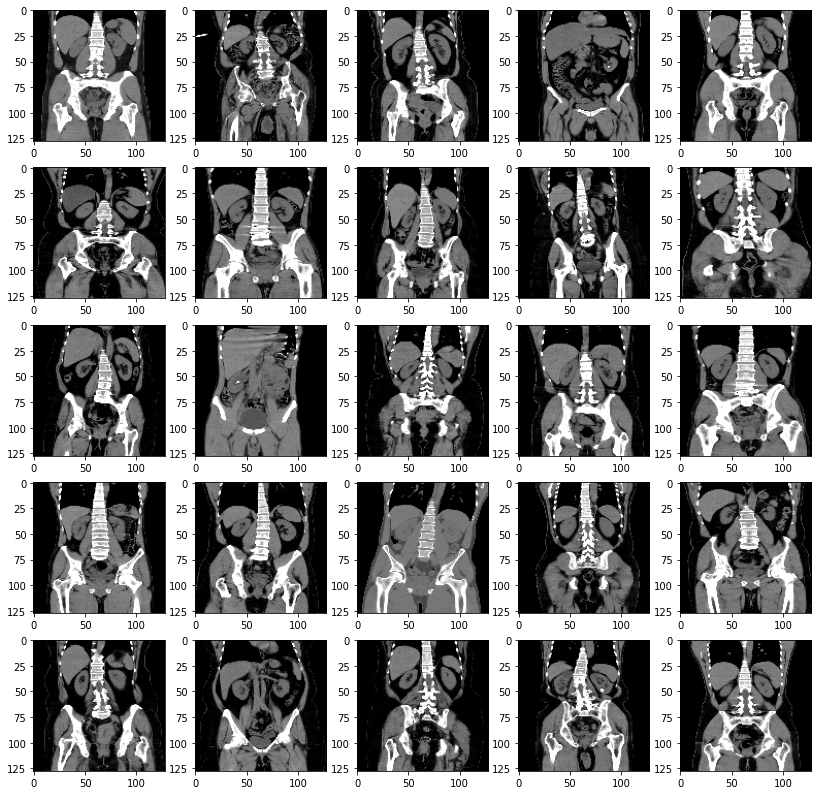

In [ ]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image[:,:,0] for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx], cmap="gray")
        idx+=1

In [ ]:
# build the model

latent_dim = 512

In [ ]:
K.clear_session()

In [ ]:
encoder_input = Input(shape = (image_size,image_size,1))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(1, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 256)        1

In [ ]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [ ]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 512),        38966912    ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 1)  13307173    ['encoder[0][2]']              

In [ ]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image[:,:,0], cmap="gray")
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/output/"
    if not os.path.exists(output_path):
      os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.png".format(epoch, step))
    plt.close()

In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 1s 1s/step
Epoch:  1
1/1 [==============================] - 1s 868ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.14295906 - KL loss: 0.0001469635
Epoch: 1 - Step: 1 - MSE loss: 0.14071754 - KL loss: 0.00014144412
Epoch: 1 - Step: 2 - MSE loss: 0.1410434 - KL loss: 0.0001283338
Epoch: 1 - Step: 3 - MSE loss: 0.14307848 - KL loss: 0.000110596804
Epoch: 1 - Step: 4 - MSE loss: 0.13885649 - KL loss: 0.000103912884
Epoch: 1 - Step: 5 - MSE loss: 0.13914779 - KL loss: 8.919839e-05
Epoch: 1 - Step: 6 - MSE loss: 0.14025992 - KL loss: 7.7256234e-05
Epoch: 1 - Step: 7 - MSE loss: 0.13903554 - KL loss: 7.217811e-05
Epoch:  2
1/1 [==============================] - 1s 836ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.13795745 - KL loss: 6.378365e-05
Epoch: 2 - Step: 1 - MSE loss: 0.13968872 - KL loss: 5.538288e-05
Epoch: 2 - Step: 2 - MSE loss: 0.14042258 - KL loss: 4.7948284e-05
Epoch: 2 - Step: 3 - MSE loss: 0.13819388 - KL loss: 4.6950503e-05
Epoch: 2 - Step: 4 - MSE 

In [ ]:
# visualize output
from google.colab.patches import cv2_imshow
import cv2
output_dir = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2_imshow( image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

In [ ]:
import imageio
img_path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/output/"
anim_file = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/cvae.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(img_path + '/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/model1.h5"
model.save(path)

# Extract features from image

In [ ]:
# load the encoder model
path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/model1.h5"
reloaded = tf.keras.models.load_model(
  path)

In [ ]:
os.path.join(train_dir,'Kidney_stone')

'/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/train/Kidney_stone'

In [ ]:
def image_preprocessor(purpose,label):
  image_dir = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/{}/{}".format(purpose,label)
  images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
  dataset = tf.data.Dataset.from_tensor_slices((images))
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(1)

  return dataset

In [ ]:
# make a function to save images while learning

def save_images(purpose, label, image_number, input_):
  image = input_[image_number] * 255
  image = image.astype("int32")
  plt.imshow(image[:,:,0], cmap="gray")
  plt.axis("off")
  
  output_path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Preprocessed/Train/{}/{}/".format(purpose,label)
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  plt.savefig(output_path + "Transformed_image{}_{}_{}.png".format(purpose, label,image_number), bbox_inches='tight')
  plt.close()

In [ ]:
data_purpose = ['train', 'val']
label = ['Kidney_stone', 'Normal']
for p in data_purpose:
  for l in label:
    before_data = image_preprocessor(p,l)
    predicted  = reloaded.predict(before_data)
    for i in range(len(predicted)):
      save_images(p,l,i,predicted)
      print(p,l,i)
     
      




101/101 [==============================] - 6s 61ms/step
train Kidney_stone 0
train Kidney_stone 1
train Kidney_stone 2
train Kidney_stone 3
train Kidney_stone 4
train Kidney_stone 5
train Kidney_stone 6
train Kidney_stone 7
train Kidney_stone 8
train Kidney_stone 9
train Kidney_stone 10
train Kidney_stone 11
train Kidney_stone 12
train Kidney_stone 13
train Kidney_stone 14
train Kidney_stone 15
train Kidney_stone 16
train Kidney_stone 17
train Kidney_stone 18
train Kidney_stone 19
train Kidney_stone 20
train Kidney_stone 21
train Kidney_stone 22
train Kidney_stone 23
train Kidney_stone 24
train Kidney_stone 25
train Kidney_stone 26
train Kidney_stone 27
train Kidney_stone 28
train Kidney_stone 29
train Kidney_stone 30
train Kidney_stone 31
train Kidney_stone 32
train Kidney_stone 33
train Kidney_stone 34
train Kidney_stone 35
train Kidney_stone 36
train Kidney_stone 37
train Kidney_stone 38
train Kidney_stone 39
train Kidney_stone 40
train Kidney_stone 41
train Kidney_stone 42
train Ki

# Building CNN Classification  Model

In [4]:
folder_name = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/"
base_dir = os.path.join(folder_name, "Train")

The dataset contains images of 2 types of imaging:

1. Kidney_stone
2. Normal

So, let's create the labels for these 2 classes:

In [5]:
labels = ['Kidney_stone', 'Normal']

Also, the dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>imaging</b>
|__ <b>train</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
|__ <b>test</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
</pre>

As you can see there are no folders containing validation data. Therefore, we will have to create our own training and validation set. 


The code below creates a `train` and a `val` folder each containing 2 folders (one for each type of condition). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>imaging</b>
|__ <b>train</b>
    |__ <b>training</b>
        |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
        |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |__ <b>validation</b>
        |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
        |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
|__ <b>test</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
</pre>

The code below also prints the total number of imaging we have for each type of flower. 

Set up paths for training and validation set

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [ ]:

# Reorganiser pictures to their deflaut folders

for cl in labels:

  train_dir = os.path.join(base_dir, 'train', cl)
  train_img = glob.glob(train_dir + '/*.png')
  val_dir = os.path.join(base_dir, 'val', cl)
  val_img = glob.glob(val_dir + '/*.png')

  for t in train_img:
    shutil.move(t, os.path.join(base_dir, cl))
  for v in val_img:
    shutil.move(v, os.path.join(base_dir, cl))

In [7]:
# Split training data to training and validation set

for cl in labels:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Kidney_stone: 126 Images
Normal: 828 Images


In [8]:
folder_name

'/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/'

In [ ]:
'''train_dir = os.path.join(folder_name, 'Train')
val_dir = os.path.join(folder_name, 'Test')

train_normal_dir = os.path.join(train_dir, 'Normal')
train_kidney_stone_dir = os.path.join(train_dir, 'Kidney_stone')
test_normal_dir = os.path.join(val_dir, 'Normal')
test_kidney_stone_dir = os.path.join(val_dir, 'Kidney_stone')'''

"train_dir = os.path.join(folder_name, 'Train')\nval_dir = os.path.join(folder_name, 'Test')\n\ntrain_normal_dir = os.path.join(train_dir, 'Normal')\ntrain_kidney_stone_dir = os.path.join(train_dir, 'Kidney_stone')\ntest_normal_dir = os.path.join(val_dir, 'Normal')\ntest_kidney_stone_dir = os.path.join(val_dir, 'Kidney_stone')"

In [ ]:
'''num_normal_tr = len(os.listdir(train_normal_dir))
num_kidney_stone_tr = len(os.listdir(train_kidney_stone_dir))

num_normal_val = len(os.listdir(test_normal_dir))
num_kidney_stone_val = len(os.listdir(test_kidney_stone_dir))

total_train = num_normal_tr + num_kidney_stone_tr
total_val = num_normal_val + num_kidney_stone_val'''

'num_normal_tr = len(os.listdir(train_normal_dir))\nnum_kidney_stone_tr = len(os.listdir(train_kidney_stone_dir))\n\nnum_normal_val = len(os.listdir(test_normal_dir))\nnum_kidney_stone_val = len(os.listdir(test_kidney_stone_dir))\n\ntotal_train = num_normal_tr + num_kidney_stone_tr\ntotal_val = num_normal_val + num_kidney_stone_val'

In [ ]:
'''print(num_normal_tr)
print(num_kidney_stone_tr)

print(num_normal_val)
print(num_kidney_stone_val)

print(total_train)
print(total_val)'''

'print(num_normal_tr)\nprint(num_kidney_stone_tr)\n\nprint(num_normal_val)\nprint(num_kidney_stone_val)\n\nprint(total_train)\nprint(total_val)'

In [9]:
batch_size = 128
IMG_SHAPE = 64

In [10]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 763 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(64,64)
                                                              class_mode='binary')

Found 191 images belonging to 2 classes.


In [13]:
labels = train_data_gen.labels

### Visualise a training Image

In [15]:
sample_training_images, _ = next(train_data_gen) 

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

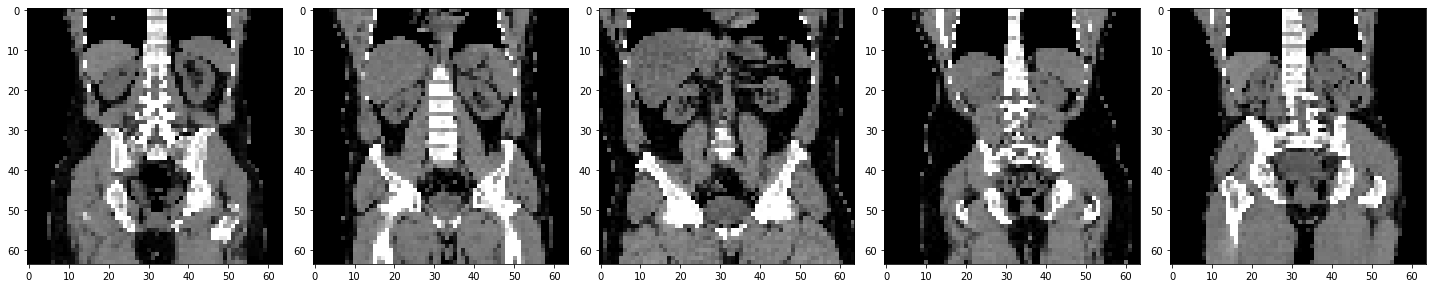

In [17]:
plotImages(sample_training_images[:5])  # Plot images 0-4

### Define Model

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

#### Model without encoder

In [21]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(763 / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(191  / float(batch_size)))
)

Epoch 1/100
6/6 [==============================] - 351s 59s/step - loss: 0.4692 - accuracy: 0.8676 - val_loss: 0.4090 - val_accuracy: 0.8691
Epoch 2/100
6/6 [==============================] - 26s 4s/step - loss: 0.3915 - accuracy: 0.8676 - val_loss: 0.3753 - val_accuracy: 0.8691
Epoch 3/100
6/6 [==============================] - 26s 4s/step - loss: 0.3817 - accuracy: 0.8676 - val_loss: 0.3717 - val_accuracy: 0.8691
Epoch 4/100
6/6 [==============================] - 26s 4s/step - loss: 0.3714 - accuracy: 0.8676 - val_loss: 0.3682 - val_accuracy: 0.8691
Epoch 5/100
6/6 [==============================] - 29s 5s/step - loss: 0.3672 - accuracy: 0.8676 - val_loss: 0.3604 - val_accuracy: 0.8691
Epoch 6/100
6/6 [==============================] - 26s 4s/step - loss: 0.3574 - accuracy: 0.8676 - val_loss: 0.3522 - val_accuracy: 0.8691
Epoch 7/100
6/6 [==============================] - 26s 4s/step - loss: 0.3486 - accuracy: 0.8676 - val_loss: 0.3551 - val_accuracy: 0.8691
Epoch 8/100
6/6 [========

# Extracting Key Areas in Image

In [4]:
import cv2
import matplotlib.pyplot as plt
import os

source_images_folder = '/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/Normal' # the folder containing all the images for ROI selection
image_names = os.listdir(source_images_folder)
destination_folder = './dest' # the folder to which the cropped images are stored

for image in image_names:
    img = cv2.imread(source_images_folder+'/'+image)
    plt.figure(figsize=(5,5))
    fig = plt.gcf()
    plt.imshow(img[240:600,280:820])  # The ROI, please keep static
    plt.draw()
    plt.savefig(destination_folder+'/'+image)
    print('saved ', image)
    break

[]

#### Model with Encoder

In [ ]:
path = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/model1.h5"
reloaded = tf.keras.models.load_model(
            path)

In [ ]:
# Load the kidney stone dataset
train_nor = os.path.join(train_dir,'Normal')
train_nor_image = [os.path.join(train_nor, image) for image in os.listdir(train_nor)]
load_train_nor_image = load_image(train_nor_image)
pred = reloaded.predict(load_image(train_nor_image))

['/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/train/Normal/1.3.46.670589.33.1.63715894847742042700001.5509827303443763175.png',
 '/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Train/train/Normal/1.3.46.670589.33.1.63737239150311509600001.5074482997916460493.png']

In [ ]:
len(pred)

662

In [ ]:
# Load the kidney stone dataset

train_ks = os.path.join(train_dir,'Kidney_stone')
train_ks_image = [os.path.join(train_ks, image) for image in os.listdir(train_ks)]
load_train_ks_image = load_image(train_ks_image)
pred2 = reloaded.predict(load_image(train_ks_image))

101/101 [==============================] - 2s 4ms/step


In [ ]:
pred[0].sum(), pred[661].sum(),pred2[0].sum(), pred2[100].sum()

(1136.8251, 986.82697, 949.89404, 1180.8475)

In [ ]:
pred[0].sum(), pred[661].sum(),pred2[0].sum(), pred2[100].sum()

(1136.8251, 986.82697, 1049.2385, 1186.6511)

In [ ]:
pred[0].sum(), pred[661].sum(),pred2[0].sum(), pred2[100].sum()

(1136.8251, 986.82697, 854.0371, 1118.3436)

In [ ]:
len(pred) + len(pred2)

763

In [ ]:
train_nor = os.path.join(train_dir,'Normal')
train_nor_image = [os.path.join(train_nor, image) for image in os.listdir(train_nor)]
train_ks = os.path.join(train_dir,'Kidney_stone')
train_ks_image = [os.path.join(train_ks, image) for image in os.listdir(train_ks)]

train_data = train_nor_image + train_ks_image

load_train_ks_image = load_image(train_data)
train_pred = reloaded.predict(load_train_ks_image)
train_label = [0 for i in range(len(train_nor_image))] + [1 for i in range(len(train_ks_image))] 
assert_equal(len(train_pred), len(train_label))

763/763 [==============================] - 11s 3ms/step


In [ ]:
train_pred[0].sum(), train_pred[661].sum(),train_pred[662].sum(), train_pred[762].sum()

(1251.6038, 1214.3804, 975.6206, 827.1839)

In [ ]:
val_nor = os.path.join(val_dir,'Normal')
val_nor_image = [os.path.join(val_nor, image) for image in os.listdir(val_nor)]
val_ks = os.path.join(val_dir,'Kidney_stone')
val_ks_image = [os.path.join(val_ks, image) for image in os.listdir(val_ks)]

val_data = val_nor_image + val_ks_image

load_val_ks_image = load_image(val_data)
val_pred = reloaded.predict(load_val_ks_image)
val_label = [0 for i in range(len(val_nor_image))] + [1 for i in range(len(val_ks_image))] 
assert_equal(len(val_pred), len(val_label))

191/191 [==============================] - 3s 4ms/step


In [ ]:
vae_model = Sequential([
    
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2)
])

In [ ]:
vae_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
train_pred.dtype

dtype('float32')

In [ ]:
train_pred = np.array(train_pred)
train_label = np.array(train_label)
val_pred = np.array(val_pred)
val_label = np.array(val_label)

In [ ]:
EPOCHS = 500
history = vae_model.fit(train_pred,train_label,
    
    steps_per_epoch=int(np.ceil(763 / float(128))),
    epochs=EPOCHS,
    validation_data=(val_pred,val_label),
    validation_steps=int(np.ceil(191  / float(128)))
)

Epoch 1/500
6/6 [==============================] - 0s 48ms/step - loss: 1.4193e-04 - accuracy: 1.0000 - val_loss: 2.4508 - val_accuracy: 0.8272
Epoch 2/500
6/6 [==============================] - 0s 30ms/step - loss: 1.3730e-04 - accuracy: 1.0000 - val_loss: 2.4529 - val_accuracy: 0.8272
Epoch 3/500
6/6 [==============================] - 0s 31ms/step - loss: 1.3388e-04 - accuracy: 1.0000 - val_loss: 2.4600 - val_accuracy: 0.8272
Epoch 4/500
6/6 [==============================] - 0s 47ms/step - loss: 1.3071e-04 - accuracy: 1.0000 - val_loss: 2.4679 - val_accuracy: 0.8272
Epoch 5/500
6/6 [==============================] - 0s 50ms/step - loss: 1.2742e-04 - accuracy: 1.0000 - val_loss: 2.4796 - val_accuracy: 0.8272
Epoch 6/500
6/6 [==============================] - 0s 46ms/step - loss: 1.2634e-04 - accuracy: 1.0000 - val_loss: 2.4891 - val_accuracy: 0.8272
Epoch 7/500
6/6 [==============================] - 0s 50ms/step - loss: 1.2176e-04 - accuracy: 1.0000 - val_loss: 2.4811 - val_accuracy:

# Building CNN Classification  Model

In [ ]:
folder_name = "/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/"
base_dir = os.path.join(folder_name, "Train")

The dataset contains images of 2 types of imaging:

1. Kidney_stone
2. Normal

So, let's create the labels for these 2 classes:

In [ ]:
labels = ['Kidney_stone', 'Normal']

Also, the dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>imaging</b>
|__ <b>train</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
|__ <b>test</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
</pre>

As you can see there are no folders containing validation data. Therefore, we will have to create our own training and validation set. 


The code below creates a `train` and a `val` folder each containing 2 folders (one for each type of condition). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>imaging</b>
|__ <b>train</b>
    |__ <b>training</b>
        |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
        |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |__ <b>validation</b>
        |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
        |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
|__ <b>test</b>
    |______ <b>Kidney_stone</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Normal</b>: [1.jpg, 2.jpg, 3.jpg ....]
</pre>

The code below also prints the total number of imaging we have for each type of flower. 

Set up paths for training and validation set

In [ ]:
en_base_dir = '/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Preprocessed/Train/'
train_dir = os.path.join(en_base_dir, 'train')
val_dir = os.path.join(en_base_dir, 'val')

In [ ]:
train_dir

'/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/Preprocessed/Train/train'

In [ ]:

'''# Reorganiser pictures to their deflaut folders

for cl in labels:

  train_dir = os.path.join(base_dir, 'train', cl)
  train_img = glob.glob(train_dir + '/*.png')
  val_dir = os.path.join(base_dir, 'val', cl)
  val_img = glob.glob(val_dir + '/*.png')

  for t in train_img:
    shutil.move(t, os.path.join(base_dir, cl))
  for v in val_img:
    shutil.move(v, os.path.join(base_dir, cl))'''

"# Reorganiser pictures to their deflaut folders\n\nfor cl in labels:\n\n  train_dir = os.path.join(base_dir, 'train', cl)\n  train_img = glob.glob(train_dir + '/*.png')\n  val_dir = os.path.join(base_dir, 'val', cl)\n  val_img = glob.glob(val_dir + '/*.png')\n\n  for t in train_img:\n    shutil.move(t, os.path.join(base_dir, cl))\n  for v in val_img:\n    shutil.move(v, os.path.join(base_dir, cl))"

In [ ]:
# Split training data to training and validation set

for cl in labels:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Kidney_stone: 0 Images
Normal: 0 Images


In [ ]:
folder_name

'/content/drive/MyDrive/Kidney_stone_detection-main/Dataset/'

In [ ]:
'''train_dir = os.path.join(folder_name, 'Train')
val_dir = os.path.join(folder_name, 'Test')

train_normal_dir = os.path.join(train_dir, 'Normal')
train_kidney_stone_dir = os.path.join(train_dir, 'Kidney_stone')
test_normal_dir = os.path.join(val_dir, 'Normal')
test_kidney_stone_dir = os.path.join(val_dir, 'Kidney_stone')'''

"train_dir = os.path.join(folder_name, 'Train')\nval_dir = os.path.join(folder_name, 'Test')\n\ntrain_normal_dir = os.path.join(train_dir, 'Normal')\ntrain_kidney_stone_dir = os.path.join(train_dir, 'Kidney_stone')\ntest_normal_dir = os.path.join(val_dir, 'Normal')\ntest_kidney_stone_dir = os.path.join(val_dir, 'Kidney_stone')"

In [ ]:
'''num_normal_tr = len(os.listdir(train_normal_dir))
num_kidney_stone_tr = len(os.listdir(train_kidney_stone_dir))

num_normal_val = len(os.listdir(test_normal_dir))
num_kidney_stone_val = len(os.listdir(test_kidney_stone_dir))

total_train = num_normal_tr + num_kidney_stone_tr
total_val = num_normal_val + num_kidney_stone_val'''

'num_normal_tr = len(os.listdir(train_normal_dir))\nnum_kidney_stone_tr = len(os.listdir(train_kidney_stone_dir))\n\nnum_normal_val = len(os.listdir(test_normal_dir))\nnum_kidney_stone_val = len(os.listdir(test_kidney_stone_dir))\n\ntotal_train = num_normal_tr + num_kidney_stone_tr\ntotal_val = num_normal_val + num_kidney_stone_val'

In [ ]:
'''print(num_normal_tr)
print(num_kidney_stone_tr)

print(num_normal_val)
print(num_kidney_stone_val)

print(total_train)
print(total_val)'''

'print(num_normal_tr)\nprint(num_kidney_stone_tr)\n\nprint(num_normal_val)\nprint(num_kidney_stone_val)\n\nprint(total_train)\nprint(total_val)'

In [ ]:
batch_size = 128
IMG_SHAPE = 64

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 763 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(64,64)
                                                              class_mode='binary')

Found 191 images belonging to 2 classes.


### Visualise a training Image

In [ ]:
sample_training_images, _ = next(train_data_gen) 

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

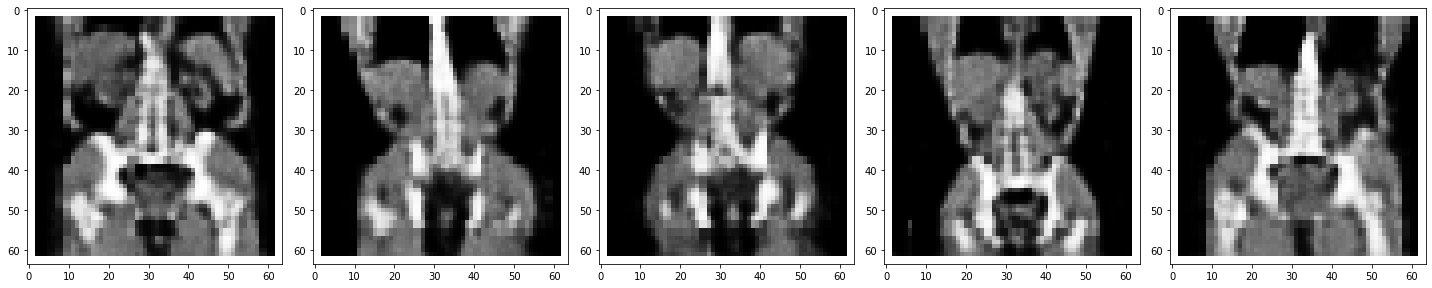

In [ ]:
plotImages(sample_training_images[:5])  # Plot images 0-4

### Define Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)       

In [ ]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(763 / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(191  / float(batch_size)))
)

Epoch 1/100
6/6 [==============================] - 9s 1s/step - loss: 0.4818 - accuracy: 0.8676 - val_loss: 0.4349 - val_accuracy: 0.8691
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.4068 - accuracy: 0.8676 - val_loss: 0.3865 - val_accuracy: 0.8691
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.3797 - accuracy: 0.8676 - val_loss: 0.3774 - val_accuracy: 0.8691
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.3744 - accuracy: 0.8676 - val_loss: 0.3718 - val_accuracy: 0.8691
Epoch 5/100
6/6 [==============================] - 8s 1s/step - loss: 0.3699 - accuracy: 0.8676 - val_loss: 0.3648 - val_accuracy: 0.8691
Epoch 6/100
6/6 [==============================] - 10s 2s/step - loss: 0.3613 - accuracy: 0.8676 - val_loss: 0.3568 - val_accuracy: 0.8691
Epoch 7/100
6/6 [==============================] - 8s 1s/step - loss: 0.3514 - accuracy: 0.8676 - val_loss: 0.3442 - val_accuracy: 0.8691
Epoch 8/100
6/6 [================